In [9]:
from qslamr import *
from model_design import INITIALDICT, GRIDDICT
import matplotlib.pyplot as plt

['QUBIT_1', 'QUBIT_3', 'QUBIT_2']
[(4.0, 3.5), (1.7, 3.2), (1.0, 2.5)]


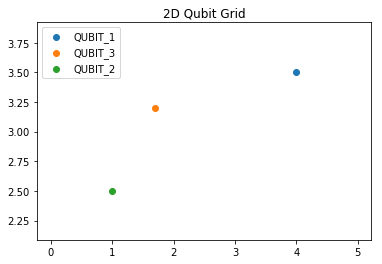

In [30]:
print GRIDDICT.keys()
print GRIDDICT.values()

GRIDDICT['QUBIT_3'] = (1.7, 3.2)
INITIALDICT['P_ALPHA'] = 3
INITIALDICT['P_BETA'] = 2

plt.figure()
plt.title("2D Qubit Grid")
for key in GRIDDICT.keys():
    plt.scatter(GRIDDICT[key][0], GRIDDICT[key][1], label=key)
plt.legend()
plt.margins(0.4)
plt.show()

In [25]:
import numpy as np

def true_noise_map(x,y, mu_x=2., mu_y=3, var_x=1, var_y=1.5):
    var = np.eye(2)
    var[0,0] = var_x
    var[1,1] = var_y
    arg = ((x- mu_x)**2 + (y- mu_y)**2 )/ 2*np.norm
    return noise_phase

In [2]:
positions = GRIDDICT.values()
test = ParticleFilter(positions, **INITIALDICT)
measurement_controls = [[1, 1]]*10 # an upstate on Qubit 1 and Qubit 3

In [3]:
test.qslamr(measurement_controls)

In InitializeParticles...

...for NEXT Alpha particle initialised in set_init_alphaparticle ...
... In set_init_alphaparticle...
... ... the initial neighbourhoood is 6.0
... ... the initial particle state is
[-1.26676545  0.45457702  1.69709597  0.8988148  -1.31882093 -0.8351716
  2.12425007  0.18882652  2.27478296  0.60594228  7.39994337  0.08717827]
... EXIT set_init_alphaparticle


...for NEXT Alpha particle initialised in set_init_alphaparticle ...
... In set_init_alphaparticle...
... ... the initial neighbourhoood is 6.0
... ... the initial particle state is
[-0.48269767  1.01797329 -0.52590117  0.07159853 -0.69501249 -0.13955673
  0.9763874   0.89339668  2.6135463   0.23446124  4.60413763  5.31743175]
... EXIT set_init_alphaparticle


...for NEXT Alpha particle initialised in set_init_alphaparticle ...
... In set_init_alphaparticle...
... ... the initial neighbourhoood is 6.0
... ... the initial particle state is
[-0.17405844 -1.67706189  0.14133177 -0.95251177  0.57640775 -0.43

qslamr.py:136: RuntimeWarning: invalid value encountered in arccos
  map_val = np.arccos(2.0*born_prob  - 1.0)


ValueError: p is nan

#### Testing the subtree generation - particularly the last tree:

#### Testing whether the resamplign function picks out all indices

In [ ]:
import numpy as np

class Resample(object):
    '''docstring'''
    
    def __init__(self):
        pass
    
    @staticmethod
    def resample_from_weights(posterior_weights, number_of_samples):
        '''docstring'''
        total_particles = len(posterior_weights)
        cdf_weights = np.asarray([0] + [np.sum(posterior_weights[:idx+1]) for idx in range(total_particles)])
        pdf_uniform = np.random.uniform(low=0, high=1.0, size=number_of_samples)

        resampled_idx = []

        for u_0 in pdf_uniform:
            j = 0
            while u_0 > cdf_weights[j]:
                j += 1
                if j > total_particles:
                    j = total_particles 
                    # print('Break - max particle index reached during sampling')
                    break   # clip at max particle index, plus zero
            resampled_idx.append(j-1) # sgift down to match python indices

        return resampled_idx    
    
    @staticmethod
    def get_subtrees(resampled_indices, pset_beta):
        '''docstring'''
    
        new_sub_trees = []

        resampled_indices.sort()
        alpha_index_0 = None
        strt_counter=0
        end_counter=0

        for idx in resampled_indices:

            alpha_index = Resample.get_alpha_node_from_treeleaf(idx, pset_beta)
            beta_alpha_idx = Resample.get_beta_node_from_treeleaf(idx, pset_beta)

            if alpha_index_0 == alpha_index:
                end_counter +=1

            elif alpha_index_0 != alpha_index:

                new_sub_trees.append([strt_counter, end_counter])

                alpha_index_0 = alpha_index
                strt_counter = end_counter
                end_counter += 1

        if end_counter == len(resampled_indices):
            end_counter += 1
            new_sub_trees.append([strt_counter, end_counter])

        return new_sub_trees
    
    @staticmethod
    def get_alpha_node_from_treeleaf(leaf_index, pset_beta):
        '''docstring'''
        alpha_node = int(leaf_index//float(pset_beta))
        return alpha_node

    @staticmethod
    def get_beta_node_from_treeleaf(leaf_index, pset_beta):
        '''docstring'''
        beta_node = int(leaf_index - int(leaf_index//float(pset_beta))*pset_beta)
        return beta_node
    
    @staticmethod
    def collapse_beta(subtree_list, resampled_indices, pset_beta):
        '''docstring'''

        state_update = 0.
        new_alpha_particle_list = []
        
        for subtree in subtree_list:

            leaves_of_subtree = resampled_indices[subtree[0]:subtree[1]]
            leaf_count = float(len(leaves_of_subtree))
            print "The subtree is defined by the endpoint index boundaries", subtree
            print "The leaves of the subtree are ", leaves_of_subtree

            if leaf_count != 0:

                normaliser = (1./leaf_count)
                alpha_node = Resample.get_alpha_node_from_treeleaf(leaves_of_subtree[0], pset_beta)
                               # resampled_indices[subtree[0]], pset_beta)
                beta_alpha_nodes = [Resample.get_beta_node_from_treeleaf(leafy, pset_beta) for leafy in leaves_of_subtree]
                               # resampled_indices[subtree[0]:subtree[1]]] 
                print "The subtree has alpha node of: ", alpha_node 
                print "The leaves of the subtree are labeled by beta indices", beta_alpha_nodes
                
#                 r_est_subtree = 0.0
#                 for node in beta_alpha_nodes:
                    
#                     beta_state = self.AlphaSet.particles[alpha_node].BetaAlphaSet_j.particles[node].particle
#                     node_j = self.AlphaSet.particles[alpha_node].node_j
#                     beta_lengthscale = beta_state[int(node_j)]
#                     r_est_subtree += normaliser*beta_lengthscale

#                 parent = self.AlphaSet.particles[alpha_node].particle
#                 parent[self.AlphaSet.particles[alpha_node].node_j] = r_est_subtree

#                 # Beta Layer Collapsed
#                 self.AlphaSet.particles[alpha_node].particle = parent
#                 self.AlphaSet.particles[alpha_node].BetaAlphaSet_j = None

#                 # New Alphas Stored
#                 new_alpha_particle_list.append(self.AlphaSet.particles[alpha_node])
#         print
#         return new_alpha_particle_list


In [ ]:
pset_alpha=2 #0 ==== 1==== 2 ===
pset_beta=2 #0, 1 == 2, 3, == 4,5
particles = pset_beta*pset_alpha
posterior_weights = list((1.0 / float(particles))*np.ones(particles))
number_of_samples = 10

resampled = Resample.resample_from_weights(posterior_weights, number_of_samples)
alphas = [Resample.get_alpha_node_from_treeleaf(index, pset_beta) for index in resampled]

import matplotlib.pyplot as plt
plt.figure()
plt.hist(resampled, bins=len(posterior_weights))
plt.show()

print "unique values", set(list(alphas))
print "resamp", resampled
print "alphas", alphas
print len( set(list(resampled))) == particles
print len( set(list(alphas))) == pset_alpha

In [ ]:
subtree_boundaries = Resample.get_subtrees(resampled, pset_beta)
print subtree_boundaries

for subtree in subtree_boundaries:
    #alpha_node = Resample.get_alpha_node_from_treeleaf(pairs[0], pset_beta)
    #beta_alpha_nodes = [Resample.get_beta_node_from_treeleaf(leafy, pset_beta) for leafy in subtree]
    print 
    print "The subtree endpoints are", subtree
    print "The leaves of the subtree are ", resampled[subtree[0]:subtree[1]]
    print "The subtree has alpha node of: ", Resample.get_alpha_node_from_treeleaf(resampled[subtree[0]], pset_beta)
    print "The leaves of the subtree are labeled by beta indices", [Resample.get_beta_node_from_treeleaf(leafy, pset_beta) for leafy in resampled[subtree[0]:subtree[1]]]
    print

In [ ]:
Resample.collapse_beta(subtree_boundaries, resampled, pset_beta)

#### Test unpacking of a slice of an array into elements

In [ ]:
nodes = 3
statetype = 4
a = range(nodes*statetype)

In [ ]:
a[0::nodes]

In [ ]:
a[1::nodes]

In [ ]:
x, y, z, r = a[2::nodes]

#### Test the flattening of lists into arrays - cases of success and failure

In [ ]:
x = [[3.4, 2.0],[2, 1]]
y = [[3.4],[2, 1]]
z = [3.4,[2, 1]]

In [ ]:
np.asarray(x).flatten()

In [ ]:
np.asarray(y).flatten()

In [ ]:
np.asarray(z).flatten()